In [71]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi
import magnetic_boundaries as mb

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

In [99]:
def generate_rectangle(Lx, Ly, plot_shape = False):
    '''Generates the set of points in the grid closest to a rectangle with sides Lx and Ly and the angle of the normal vector.
    - Lx: int
    - Ly: int
    - plot_shape: bool
    Returns
    - boundary_points: ndarray (2,2*(Lx+Ly-2))
    - normal_angles: ndarray (2*(Lx+Ly-2))'''

    x1 = Lx*np.ones(Ly-1)
    y1 = np.linspace(1,Ly, Ly-1, endpoint=False)
    angles1 = np.zeros(Ly-1)
    x2 = np.linspace(Lx-1,0, Lx-1, endpoint = False)
    y2 = Ly*np.ones(Lx-1)
    angles2 = (pi/2)*np.ones(Lx-1)
    
    x3 = np.zeros(Ly-1)
    y3 = np.linspace(Ly-1,0, Ly-1, endpoint=False)
    angles3 = pi*np.ones(Ly-1)
    x4 = np.linspace(1,Lx, Lx-1, endpoint = False)
    y4 = np.zeros(Lx-1)
    angles4 = -(pi/2)*np.ones(Lx-1)

    x = np.concatenate((x1,x2,x3,x4))
    y = np.concatenate((y1,y2,y3,y4))

    
    normal_angles = np.concatenate((angles1,angles2,angles3,angles4))
    boundary_points = np.stack((x,y)) #+ np.array([[1]*(len(normal_angles)),[1]*(len(normal_angles))])
    
    return boundary_points, normal_angles

In [100]:
def operators_rectangle(parameters, return_shape = False):
    '''
    Returns operators Phi, H and P for a rectangle 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.
    -parameters: dict
    -return_shape = bool
    Returns
    -Phi: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -H: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -P: csc_matrix (2*Lx*Ly-2*(Lx+Ly-2)-4,2*Lx*Ly-2*(Lx+Ly-2)-4)
    -indices_to_delete: list
    '''
    #The parameters dictionary must have the following key,value pairs
    theta = parameters['theta'] #float in (-pi,pi] Boundary condition angle
    gap = parameters['mass']    #float Mass gap
    Lx = parameters['Lx']       #int Number of lattice sites in x direction
    Ly = parameters['Ly']       #int Number of lattice sites in y direction
    Nx = Lx+1
    Ny = Ly+1
    a_e = parameters['a_e']   #ndarray(Lx,Ly+1) Peierls phases to the right 
    a_n = parameters['a_n']   #ndarray(Lx+1,Ly) Peierls phases up
    #Attach zeros to the Peierls phases to fix their size.
    a_e = np.concatenate([a_e,np.zeros((Ly+1,1))],axis = 1)
    a_n = np.concatenate([a_n,np.zeros((1,Lx+1))],axis = 0)

    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
                
        #Phases
        phase_e = np.exp(1j*a_e[y,x])
        phase_n = np.exp(1j*a_n[y,x])
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2
       
    mass = scipy.sparse.spdiags(gap*np.ones(Nx*Ny), 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@M@Phi
        
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_rectangle(Lx, Ly)
    # The parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    indices_to_delete = []
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    def discriminant(x,y):
        return x>0 and x<Lx and y>0 and y<Ly
        
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if not discriminant(x,y) and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete

(8, 10) (8, 1)


Text(0.5, 1.0, 'Lattice')

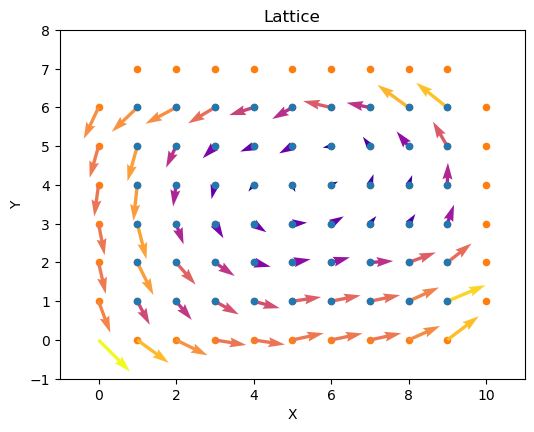

In [76]:
Lx = 10
Ly = 7
fluxes = np.random.rand(Ly,Lx)/1000
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "C4")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta = -(pi/2)*(0/100),
    a_e = a_e,
    a_n = a_n,
    mass = 0
)

Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_rectangle(parameters, return_shape = True)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
# Define a grid of points
x = np.linspace(0, Lx-1, Lx) 
y = np.linspace(0, Ly-1, Ly)  
X, Y = np.meshgrid(x, y)    # Create a meshgrid for plotting
ax.quiver(X, Y, a_e[:-1,:], a_n[:,:-1],np.sqrt(a_e[:-1,:]**2 + a_n[:,:-1]**2),cmap="plasma") #The right and top edges are left out of the plot
ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
#ax.imshow(fluxes,extent=[0, Lx, 0, Ly],zorder = -2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-1,Lx+1)
ax.set_ylim(-1,Ly+1)
ax.set_aspect('equal')
ax.set_title('Lattice')



In [101]:
def solve_eigenproblem_rectangle(parameters, energy = 1e-6, number_of_bands = 10, plot_shape = True):
    '''
    Returns spectrum and eigenstates (and deleted indices) of a rectangular system.
    - parameters: dict
    - energy: float Value of the energy around which to calculate spectrum
    - number_of_bands: int Amount of bands closest to energ to calculate.
    - plot_shape: bool
    Returns:
    - energies: ndarray (number_of_bands)
    - states_shaped: ndarray((Lx+1)*(Ly+1),number_of_bands)
    - deleted_indeices: list
    '''
    #The parameters dictionary must have the following key,value pairs
    Lx = parameters['Lx']       #int Number of lattice sites in x direction
    Ly = parameters['Ly']       #int Number of lattice sites in y direction
    Nx = Lx+1
    Ny = Ly+1
   
    if plot_shape:
        Phi, H, P, deleted_indices, spinup_shape, spindown_shape = operators_rectangle(parameters, return_shape = True)
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111)
        ax.scatter(spinup_shape[0],spinup_shape[1], s = 20)
        ax.scatter(spindown_shape[0],spindown_shape[1], s = 20,zorder=-1)
        ax.set_aspect('equal')
        fig.show()
    else:
        Phi, H, P, deleted_indices = operators_rectangle(parameters, return_shape = False)

      #Solve generalised eigenproblem
    eigenvalues, eigenvectors = sla.eigsh(H, M=P, k = number_of_bands, tol = 1e-8, sigma = energy, which = 'LM',return_eigenvectors = True)

    #Refill with zeros the deleted spins
    states = np.zeros((2*Nx*Ny,number_of_bands),dtype = complex)
    count = 0
    for index in range(2*Nx*Ny):
        if index not in deleted_indices:
            states[index] = (Phi@eigenvectors)[index-count]
        else:
            count += 1

    #Now make sure they are orthogonal
    overlaps = states.conjugate().transpose()@states
    ##The overlap can only be non-zero for degenerate states
    degenerate_indices = []
    bulk_indices = []    
    for i in range(overlaps.shape[0]):
        sorted = np.flip(np.sort(np.abs(overlaps[i])))
        if sorted[1]/sorted[0]<0.1: #This threshold (0.1) is a bit arbitrary
            bulk_indices.append(i)
        else:
            degenerate_indices.append(i)

    overlaps_deg = np.delete(overlaps, bulk_indices, axis=0)
    overlaps_deg = np.delete(overlaps_deg, bulk_indices, axis=1)
    overlaps_bulk = np.delete(overlaps, degenerate_indices, axis=0)
    overlaps_bulk = np.delete(overlaps_bulk, degenerate_indices, axis=1)

    states_deg = np.delete(states, bulk_indices, axis=1)
    states_bulk = np.delete(states, degenerate_indices, axis=1)

    evalues, orthogonal_coeff = np.linalg.eigh(overlaps_deg)
    orthogonal = np.append(states_deg@orthogonal_coeff, states_bulk , axis=1) #### These are finally the orthogonalised states
    norm = np.sqrt(np.diag(np.abs(orthogonal.conjugate().transpose()@orthogonal)))
    states = orthogonal/norm[None,:]
    
    # Rebuild state
    def spin_rotation(site, theta, phi):
        '''Returns a unitary transformation matrix that rotates the spin site to a theta,phi orientation'''
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = int(site[0] + site[1]*Nx)
        spindown = int(site[0] + site[1]*Nx + Nx*Ny)
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # We need to generate again the shape in order to refill the deleted sites
    edge_points, normal_angles = generate_rectangle(Lx, Ly)
    # The parameter that we need for the spin rotation is the projection of the boundary spin on the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    # Rotate back the spins on the edge
    theta = parameters['theta']
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        rotation = spin_rotation([point[0],point[1]], theta, point[2]+pi)
        states = rotation@states

    ### Reshape
    states_shaped = np.reshape(states.flatten('F'), newshape = (number_of_bands,2,Ny,Nx), order = 'C')

    ### Assign again energies
    energies = np.zeros(number_of_bands)
    for i in range(number_of_bands):
        if i in degenerate_indices:
            energies[i] = 0
        else:
            energies[i] = eigenvalues[i]
    
    return energies, states_shaped, degenerate_indices

/tmp/ipykernel_104031/1556298412.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


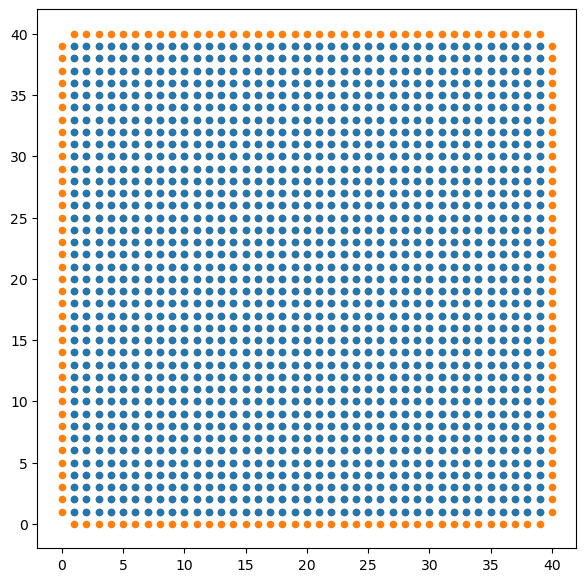

In [69]:
Lx = 40
Ly = 40
fluxes = np.random.rand(Ly,Lx)/10
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "C4")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    theta = -0*(pi/2)+pi,
    a_e = a_e,
    a_n = a_n,
    mass = 0#/np.sqrt(Lx*Ly)
)
nbands = 100
ener, states, degenerate_indices = solve_eigenproblem_rectangle(parameters, number_of_bands = nbands, plot_shape=True)

/tmp/ipykernel_104031/1856709183.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


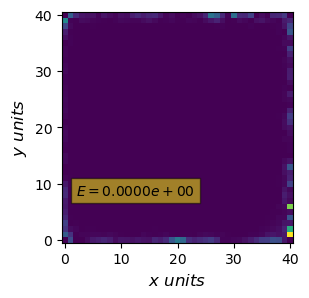

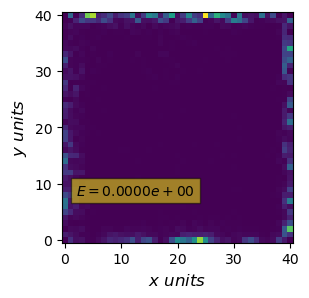

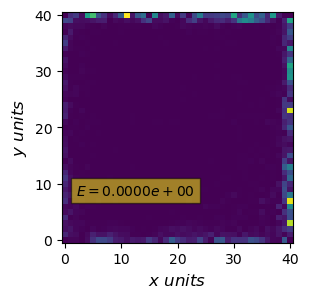

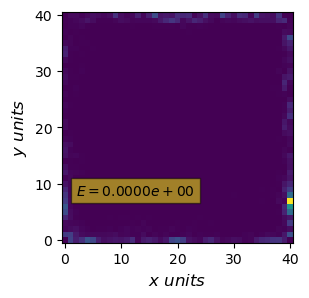

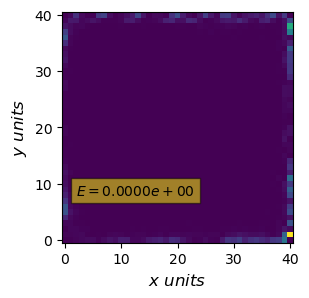

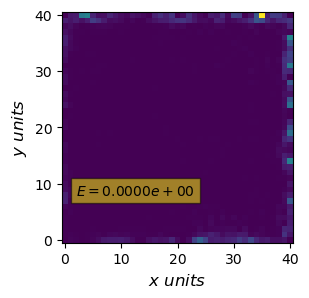

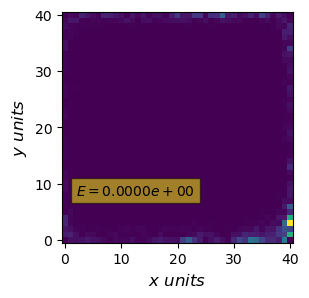

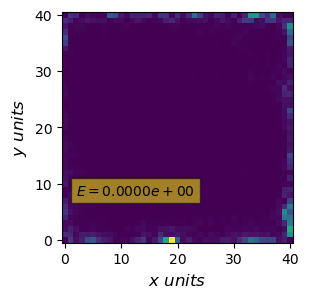

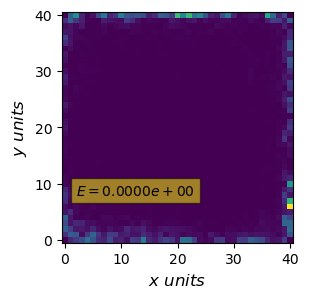

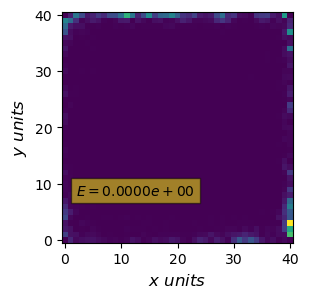

In [68]:
for i in range(nbands):
    to_plot = states[i,:,:,:]

    fig = plt.figure(figsize = (3,3))
    ax = fig.add_subplot(111)
    
    ax.imshow(np.sum(np.abs(to_plot)**2,axis = 0),vmin = 0, origin = "lower")
    #ax.imshow(np.abs(to_plot[1])**2,vmin = 0,cmap = 'cividis') This would plot only spin down probability density
    formatted_number = f"{ener[i]:.4e}"
    plt.text(2, 8,rf'$E ={formatted_number}$' , fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    
    ax.set_ylabel(r"$y$ $units$",fontsize = 12)
    ax.set_xlabel(r"$x$ $units$",fontsize = 12)
    
    fig.show()

[35, 36, 37, 41, 47, 49, 51, 53, 61, 68, 72, 82, 94, 102, 111, 122, 123, 136, 153]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


Text(0.5, 1.0, 'First five eigenvalues with $m = 1$')

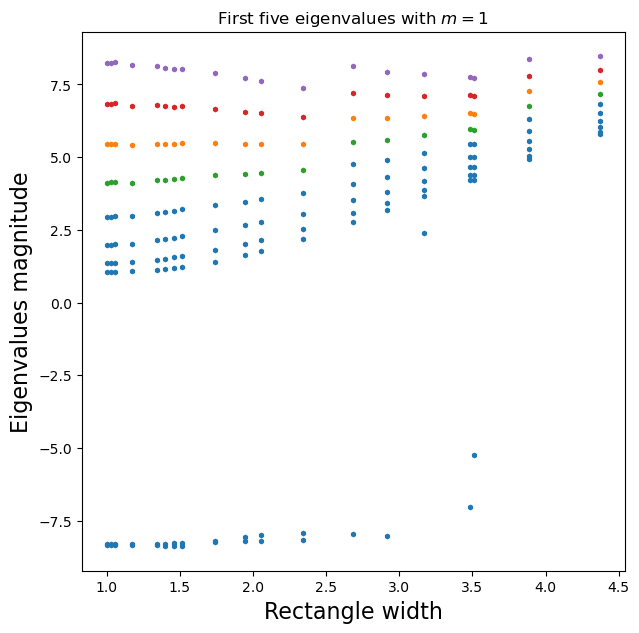

In [107]:
#Benchmarking against previous results arXiv:2403.18556 and arXiv:2411.11564

### FIGURE 5
#This part reproduces the lattice data of figure 5.
#The scale factor in the paper is 80
scale_factor = 35

area = scale_factor*scale_factor 
nbands = 10
parameters = dict()
parameters['theta'] = -pi/2
parameters['mass'] = 1/scale_factor

flux_quanta = -6
magnetic_field = 2*pi/area*flux_quanta


sides = [x for x in range(scale_factor,5*scale_factor,1) if abs(x*round(scale_factor**2/x)/(scale_factor**2)-1)<0.005]
print(sides)

spectrum = np.zeros((len(sides),nbands))
for i,side in enumerate(sides):
    print(i)
    Lx = side
    Ly = round(area/Lx)
    parameters['Lx'] = Lx
    parameters['Ly'] = Ly
    fluxes = magnetic_field*np.ones((Ly,Lx))
    a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "C4")
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    ener, states, degenerate_indices = solve_eigenproblem_rectangle(parameters, number_of_bands = nbands, plot_shape=False)
    spectrum[i] = np.sort(ener)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
colors = ['C0','C0','C0','C0','C0','C0','C2','C1','C3','C4']
for i in range(nbands):
    ax.scatter(np.array(sides)/scale_factor,scale_factor*spectrum[:,i],c = colors[i], s = 10, marker = 'h')
#ax.set_ylim(2.9,9.1)
ax.set_xlabel('Rectangle width', fontsize = 16)
ax.set_ylabel('Eigenvalues magnitude', fontsize = 16)
ax.set_title(r'First five eigenvalues with $m = 1$', fontsize = 12)
#fig.savefig('figure_5.pdf')